<a href="https://colab.research.google.com/github/Vidi005/COVID-19-Prediction-Indonesia/blob/master/COVID_19_Prediciton_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediksi Kasus Penyebaran COVID-19 di Indonesia**

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

## Mengambil Dataset

Catatan: Dataset kasus COVID-19 di Indonesia yang digunakan terakhir diupdate pada 25 Agustus 2020 dalam format "*.csv".
<br>
Sumber dataset : https://data.humdata.org/dataset/indonesia-covid-19-cases-recoveries-and-deaths-per-province

In [2]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/COVID-19-Prediction-Indonesia/trunk/datasets > /dev/null

## Menampilkan Tabel

In [3]:
data=pd.read_csv("datasets/Daily-Update IDN-COVID19 - Sheet5.csv")
data=data.rename(columns={"Date": "Tanggal",                                                     
                          "New_case_perDay": "Terkonfirmasi",
                          "Death_cases_perDay": "Meninggal",
                          "Recovered-cases_perDay": "Sembuh",
                          "Treatment_cases_perDay": "Aktif",
                          "Recovered_cases": "Jumlah Sembuh",
                          "Total_death": "Jumlah Meninggal",
                          "Patient_under_treatment": "Jumlah Aktif",
                          "Cumulative_cases": "Jumlah Kasus"})
data.head(-1)

,Tanggal,Jumlah Kasus,Jumlah Sembuh,Jumlah Meninggal,Jumlah Aktif,Terkonfirmasi,Sembuh,Meninggal,Aktif
0,2020-03-02,2,NaN,NaN,2,2,NaN,NaN,2
1,2020-03-03,2,NaN,NaN,2,2,NaN,NaN,2
2,2020-03-04,2,NaN,NaN,2,2,NaN,NaN,2
3,2020-03-05,2,NaN,NaN,2,2,NaN,NaN,2
4,2020-03-06,4,NaN,NaN,4,2,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...
171,2020-08-20,147211,100674.0,6418.0,40119,2266,2017.0,72.0,177
172,2020-08-21,149408,102991.0,6500.0,39917,2197,2317.0,82.0,-202
173,2020-08-22,151498,105198.0,6594.0,39706,2090,2207.0,94.0,-211
174,2020-08-23,153535,107500.0,6680.0,39355,2037,2302.0,86.0,-351


## Memvisualisasikan Data pada Grafik

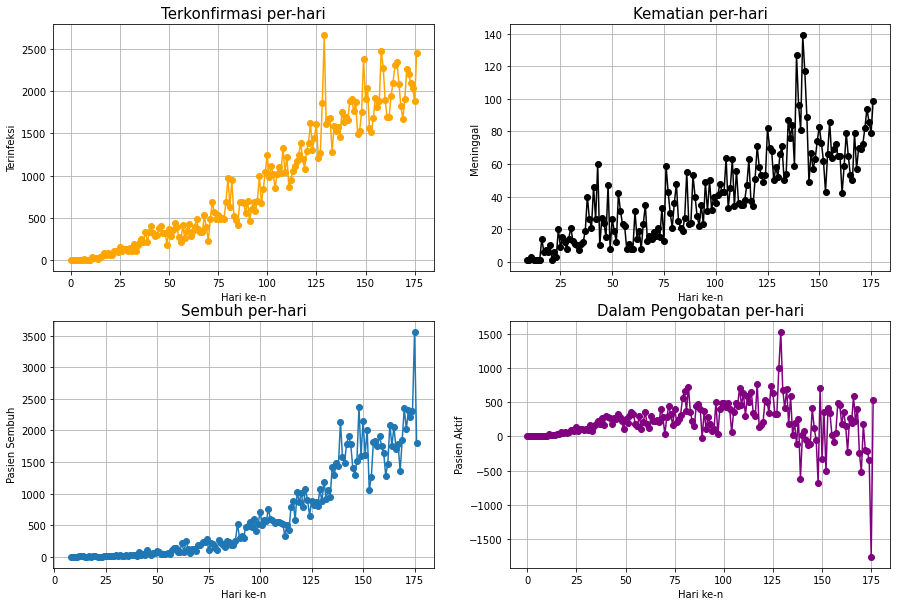

In [4]:
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(data.aggregate("Terkonfirmasi",axis=0), marker="o", color="orange")
plt.xlabel("Hari ke-n")
plt.ylabel("Terinfeksi")
plt.title("Terkonfirmasi per-hari", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 2)
plt.plot(data.aggregate("Meninggal",axis=0), marker="o", color="black")
plt.xlabel("Hari ke-n")
plt.ylabel("Meninggal")
plt.title("Kematian per-hari", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 3)
plt.plot(data.aggregate("Sembuh",axis=0), marker='o')
plt.xlabel("Hari ke-n")
plt.ylabel("Pasien Sembuh")
plt.title("Sembuh per-hari", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 4)
plt.plot(data.aggregate("Aktif",axis=0), marker='o', color="purple")
plt.xlabel("Hari ke-n")
plt.ylabel("Pasien Aktif")
plt.title("Dalam Pengobatan per-hari", size=15)
plt.grid(zorder = 0)
plt.show()

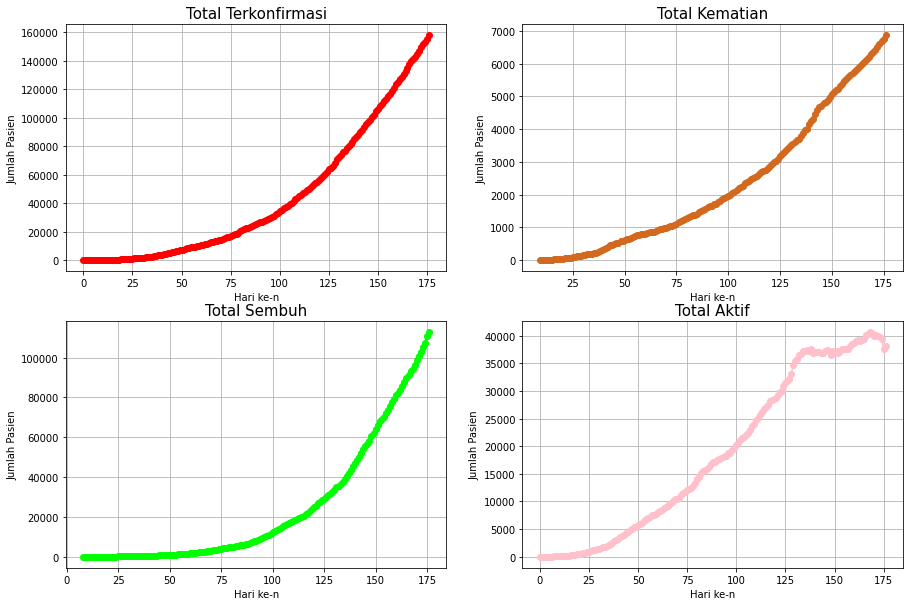

In [5]:
fig = plt.figure(figsize = (10, 7))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(data.aggregate("Jumlah Kasus",axis=0), marker="o", color="red")
plt.xlabel("Hari ke-n")
plt.ylabel("Jumlah Pasien")
plt.title("Total Terkonfirmasi", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 2)
plt.plot(data.aggregate("Jumlah Meninggal",axis=0), marker="o", color="chocolate")
plt.xlabel("Hari ke-n")
plt.ylabel("Jumlah Pasien")
plt.title("Total Kematian", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 3)
plt.plot(data.aggregate("Jumlah Sembuh",axis=0), marker="o", color="lime")
plt.xlabel("Hari ke-n")
plt.ylabel("Jumlah Pasien")
plt.title("Total Sembuh", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 4)
plt.plot(data.aggregate("Jumlah Aktif",axis=0), marker="o", color="pink")
plt.xlabel("Hari ke-n")
plt.ylabel("Jumlah Pasien")
plt.title("Total Aktif", size=15)
plt.grid(zorder = 0)
plt.show()

## Memprediksi Jumlah Kasus dengan *Logistic Distribution*

In [6]:
def plot_predict(case, future_days):
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)

    # function to be minimized
    def f_sigmoid(x, a, b, c):
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        return (c / (1 + np.exp(-b*(x-a))))

    inception = 0    
    graph = data.groupby("Tanggal")[["Jumlah Kasus", "Jumlah Meninggal", "Jumlah Sembuh"]].sum().reset_index()[inception:]
    y = graph[case]
    x = np.arange(len(y))

    # fitting the data on the logistic function
    popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method="dogbox", bounds=([12., 0.001, y.mean()],[240., 2.5, 10*y.max()]))
    print(popt_sig)
    peakday = datetime.strftime(datetime.strptime(graph["Tanggal"][inception], "%Y-%m-%d")+timedelta(days=int(popt_sig[0])), "%Y-%m-%d")
    plt.figure(figsize=(14,7))

    x_m = np.arange(len(y)+future_days)
    y_m = f_sigmoid(x_m, *popt_sig)

    print("Prediksi:")
    for i in range(1,150):
        pday = datetime.strftime(datetime.strptime(graph["Tanggal"][inception], "%Y-%m-%d")+timedelta(days=len(y)+i-1), "%Y-%m-%d")
        print("%s: %d" % (pday, y_m[len(y)+i-1]))    
        plt.plot(x[-1]+i, y_m[len(y)+i-1], marker="o", c="g")        
    plt.plot(x, y, c="g", marker="o", label="Prediksi")    

    # creating the matplotlib visualization
    plt.plot(x_m, y_m, c="gray", marker="x", label="Sigmoid | error: "+str(avg_err(pcov_sig))) 
    plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 10)
    
    plt.plot(x, y, c="r", marker="o", label = case)
    plt.xlabel("Hari ke- ")
    plt.ylabel("Jumlah Terinfeksi")
    plt.legend(prop={"size": 15})
    plt.title("Prediksi Penyebaran COVID-19 Indonesia", size=15)
    plt.axvline(x[-1])
    plt.text(x[-1]-.5, y_m[-1], str(graph["Tanggal"][len(y)+inception-1]), size = 10)
    plt.axvline(int(popt_sig[0]))
    plt.text(int(popt_sig[0]), 1, "Puncak: Hari ke - " + str(int(popt_sig[0])) + " (" + peakday + ")", size = 10)   
    plt.grid(zorder = 0) 
    plt.show()    

## Menampilkan Hasil Prediksi Sampai 150 Hari ke depan

Menampilkan hasil prediksi per hari dan memetakan hasil prediksinya pada grafik sigmoid
<br>
Parameter yang digunakan tersedia pada: https://medium.com/analytics-vidhya/predicting-the-spread-of-covid-19-coronavirus-in-us-daily-updates-4de238ad8c26

[1.56498111e+02 3.20074544e-02 2.38655025e+05]
Prediksi:
2020-08-26: 157132
2020-08-27: 158841
2020-08-28: 160533
2020-08-29: 162205
2020-08-30: 163859
2020-08-31: 165492
2020-09-01: 167106
2020-09-02: 168699
2020-09-03: 170272
2020-09-04: 171822
2020-09-05: 173352
2020-09-06: 174859
2020-09-07: 176344
2020-09-08: 177806
2020-09-09: 179246
2020-09-10: 180662
2020-09-11: 182056
2020-09-12: 183426
2020-09-13: 184773
2020-09-14: 186097
2020-09-15: 187397
2020-09-16: 188673
2020-09-17: 189926
2020-09-18: 191156
2020-09-19: 192362
2020-09-20: 193544
2020-09-21: 194704
2020-09-22: 195840
2020-09-23: 196953
2020-09-24: 198043
2020-09-25: 199110
2020-09-26: 200155
2020-09-27: 201177
2020-09-28: 202177
2020-09-29: 203155
2020-09-30: 204112
2020-10-01: 205047
2020-10-02: 205960
2020-10-03: 206853
2020-10-04: 207725
2020-10-05: 208576
2020-10-06: 209408
2020-10-07: 210219
2020-10-08: 211011
2020-10-09: 211784
2020-10-10: 212538
2020-10-11: 213273
2020-10-12: 213990
2020-10-13: 214689
2020-10-14: 

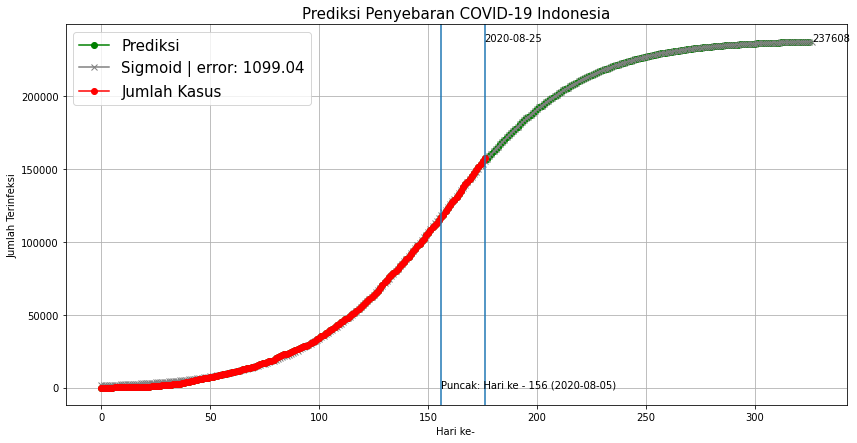

In [7]:
plot_predict("Jumlah Kasus", 150)

### Prediksi per Hari

In [8]:
def plot_predict(case, future_days):
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)

    # function to be minimized
    def f_sigmoid(x, a, b, c):
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        return (c / (1 + np.exp(-b*(x-a))))

    day = 0    
    graph_day = data.groupby("Tanggal")[["Jumlah Kasus", "Meninggal", "Sembuh"]].sum().reset_index()[day:]    
    y = graph_day[case]
    x = np.arange(len(y))

    popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method="dogbox", bounds=([12., 0.001, y.mean()],[240., 2.5, 10*y.max()]))
    print(popt_sig)    
    peakday = datetime.strftime(datetime.strptime(graph_day["Tanggal"][day], "%Y-%m-%d")+timedelta(days=int(popt_sig[0])), "%Y-%m-%d")
    plt.figure(figsize=(14,7))

    x_m = np.arange(len(y)+future_days)
    y_m = f_sigmoid(x_m, *popt_sig)
    
    for i in range(1,150):
        pday = datetime.strftime(datetime.strptime(graph_day["Tanggal"][day], "%Y-%m-%d")+timedelta(days=len(y)+i-1), "%Y-%m-%d")          
        plt.plot(x[-1]+i, (y_m[len(y)+i])-(y_m[len(y)+i-1]), marker="o", c="g")
    
    #plt.plot(x_m, (y_m-y_m[i-1]), c="gray", marker="x")
    plt.plot(data.aggregate("Terkonfirmasi",axis=0), marker="o", color="orange", label="Kasus per hari")            
    plt.axvline(x[-1])
    plt.text(x[-1]-.5, y_m[0], str(graph_day["Tanggal"][len(y)+day-1]), size = 10)
    plt.axvline(int(popt_sig[0]))
    plt.text(int(popt_sig[0]), 1, "Puncak: Hari ke - " + str(int(popt_sig[0])) + " (" + peakday + ")", size = 10)
    plt.xlabel("Hari ke-n")
    plt.ylabel("Terinfeksi")
    plt.title("Prediksi Penyebaran per-hari", size=15)
    plt.plot(x[-1]+i, (y_m[len(y)+i])-(y_m[len(y)+i-1]), c="g", marker="o", label="Prediksi")
    plt.legend(prop={"size": 15})
    plt.grid(zorder=0)
    plt.show

[1.56498111e+02 3.20074544e-02 2.38655025e+05]


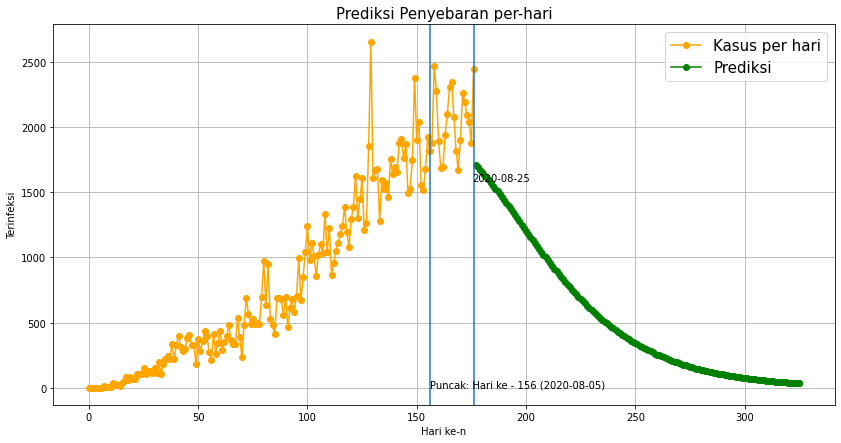

In [9]:
plot_predict("Jumlah Kasus", 150)